In [1]:
#Importing required modules
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import skimage
from skimage import feature 
from scipy.ndimage import distance_transform_edt
from skimage import measure
from skimage import morphology, segmentation 
from skimage import color
from sklearn.cluster import KMeans
%matplotlib inline

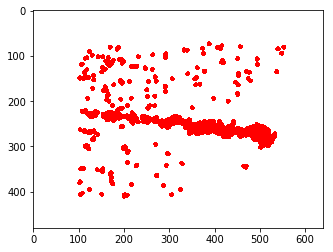

In [2]:
#Reading in original image 
original_image = cv2.imread('xy.png')
plt.imshow(original_image)
plt.show()

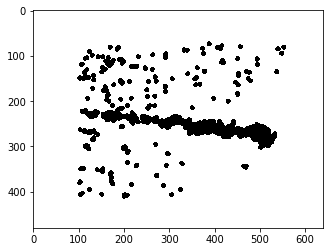

In [3]:
#Converting image to grayscale 
original_image_gray = cv2.cvtColor(original_image,cv2.COLOR_BGR2GRAY)
plt.imshow(original_image_gray, cmap="gray")
plt.show()

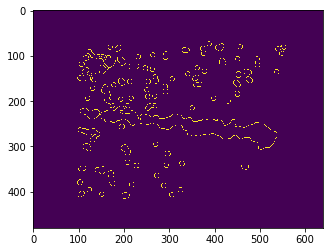

In [4]:
#Using canny edge detector to find the edges of the image
#Lower sigma - more edges detected 
edges = skimage.feature.canny(original_image_gray, sigma = 2)
plt.imshow(edges)
plt.show()

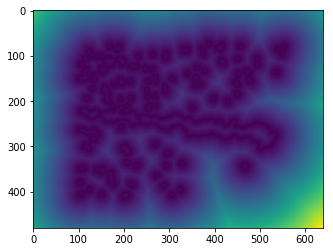

In [12]:
#Converting edge image into a landscape using distance transform
dt = distance_transform_edt(~edges)
plt.imshow(dt)
plt.show()

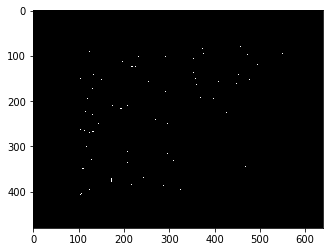

In [13]:
#Finding the locations of the fountains - local peaks 
local_max = feature.peak_local_max(dt, indices=False, min_distance=5)
plt.imshow(local_max, cmap='gray')
plt.show()

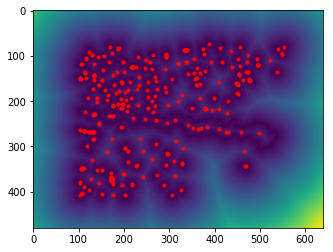

In [14]:
#Getting the coordinates of the peaks and vizualizing them better
peak_idx = feature.peak_local_max(dt, indices=True,min_distance=5)
plt.plot(peak_idx[:, 1], peak_idx[:,0], 'r.')
plt.imshow(dt)
plt.show()

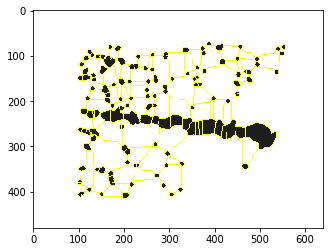

In [33]:
#Labeling segments - each point gets an integer label, so each segment has an id
markers = measure.label(local_max)
#Watershed
labels = morphology.watershed(-dt, markers)
#Vizualizing segments
plt.imshow(segmentation.mark_boundaries(original_image_gray, labels))
plt.show()

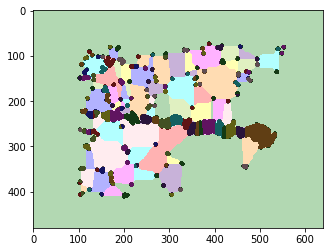

In [35]:
#Vizualizing segments better 
plt.imshow(color.label2rgb(labels, image = original_image_gray))

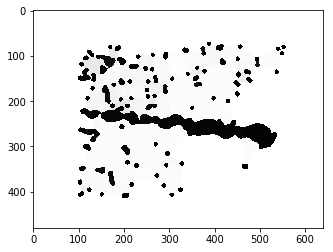

In [16]:
#Different Vizualization 
#Displaying the segments by averaging underlying pixel values 
plt.imshow(color.label2rgb (labels, image = original_image_gray, kind= 'avg'), cmap='gray')
plt.show()

In [37]:
#Merging appropriate regions together
#First distinguishing foreground from background by using K-Means clustering
regions = measure.regionprops(labels, intensity_image = original_image_gray)
region_means = [r.mean_intensity for r in regions]
model = KMeans(n_clusters=2)
region_means = np.array(region_means).reshape(-1,1)
model.fit(region_means)
print(model.cluster_centers_) #threshold for backgound and foreground 

[[246.60312376]
 [ 32.42295839]]


In [39]:
#predicts label for each region 
bg_fg_labels = model.predict(region_means)

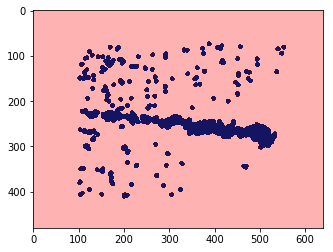

In [48]:
#Labeling image appropriately
classified_labels = labels.copy()
for bg_fg, region in zip(bg_fg_labels, regions):
    classified_labels[tuple(region.coords.T)] = bg_fg
    segmented_image = color.label2rgb(classified_labels, image = original_image_gray)
plt.imshow(segmented_image)
plt.savefig('segmented_image.png')
plt.show()

In [46]:
#New labels are in classified_labels 
#Finding the area convered by the segments using region props
new_regions = measure.regionprops(classified_labels, intensity_image = original_image_gray)
region_areas = [r.area for r in new_regions]
print(region_areas)

[23200]


In [47]:
measure.regionprops?